## DATA IMPORT

In [11]:
import pandas as pd  # Data manipulation
import numpy as np  # Numerical operations
import matplotlib.pyplot as plt  # Visualization
import seaborn as sns  # Advanced visualization

application_df = pd.read_csv("application_record.csv")
credit_df = pd.read_csv("credit_record.csv")

application_df.info()
credit_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

## DESCRIPTIVE STATISTICS

Missing values in application data:
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134203
CNT_FAM_MEMBERS             0
AGE                         0
YEARS_EMPLOYED              0
dtype: int64

Missing values in credit data:
MONTHS_BALANCE    0
STATUS            0
dtype: int64

Missing values in OCCUPATION_TYPE: 134203


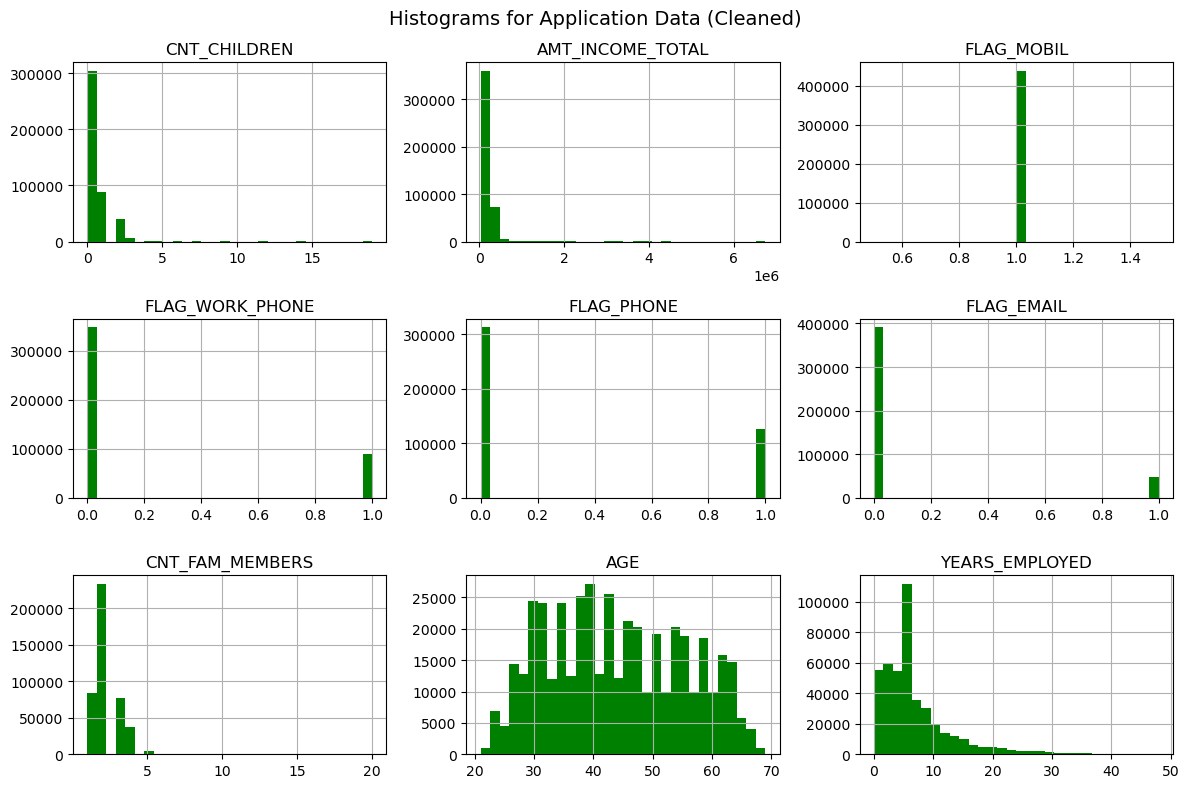

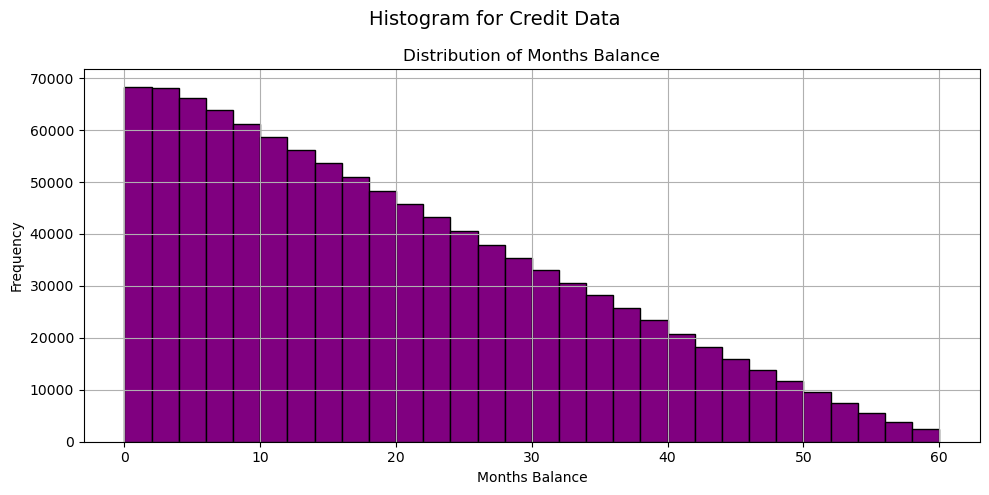

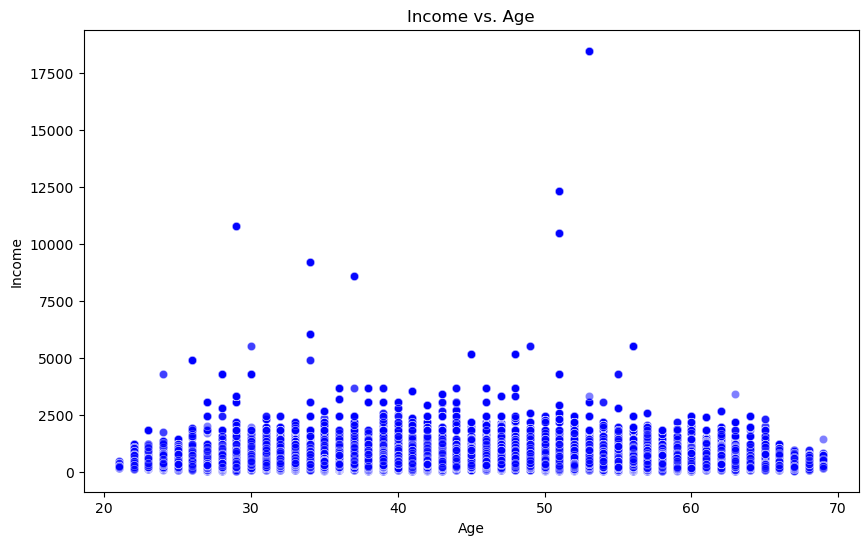

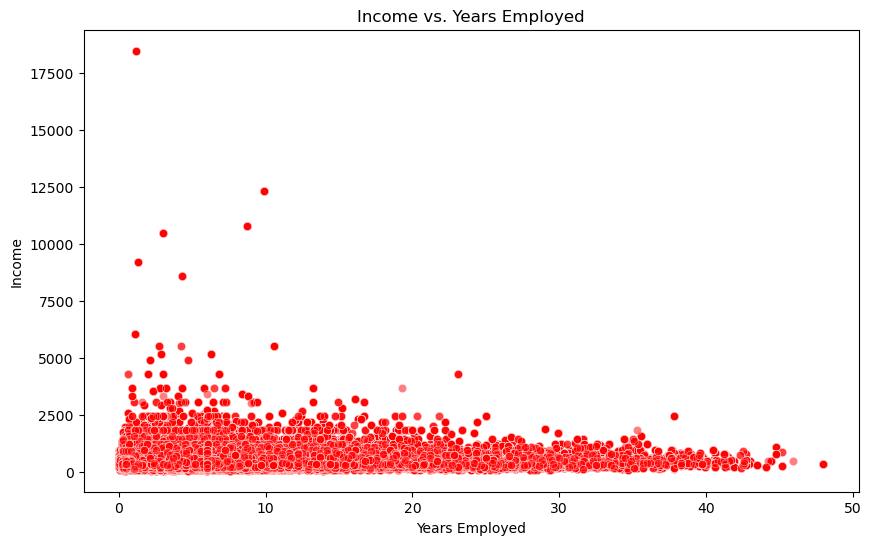

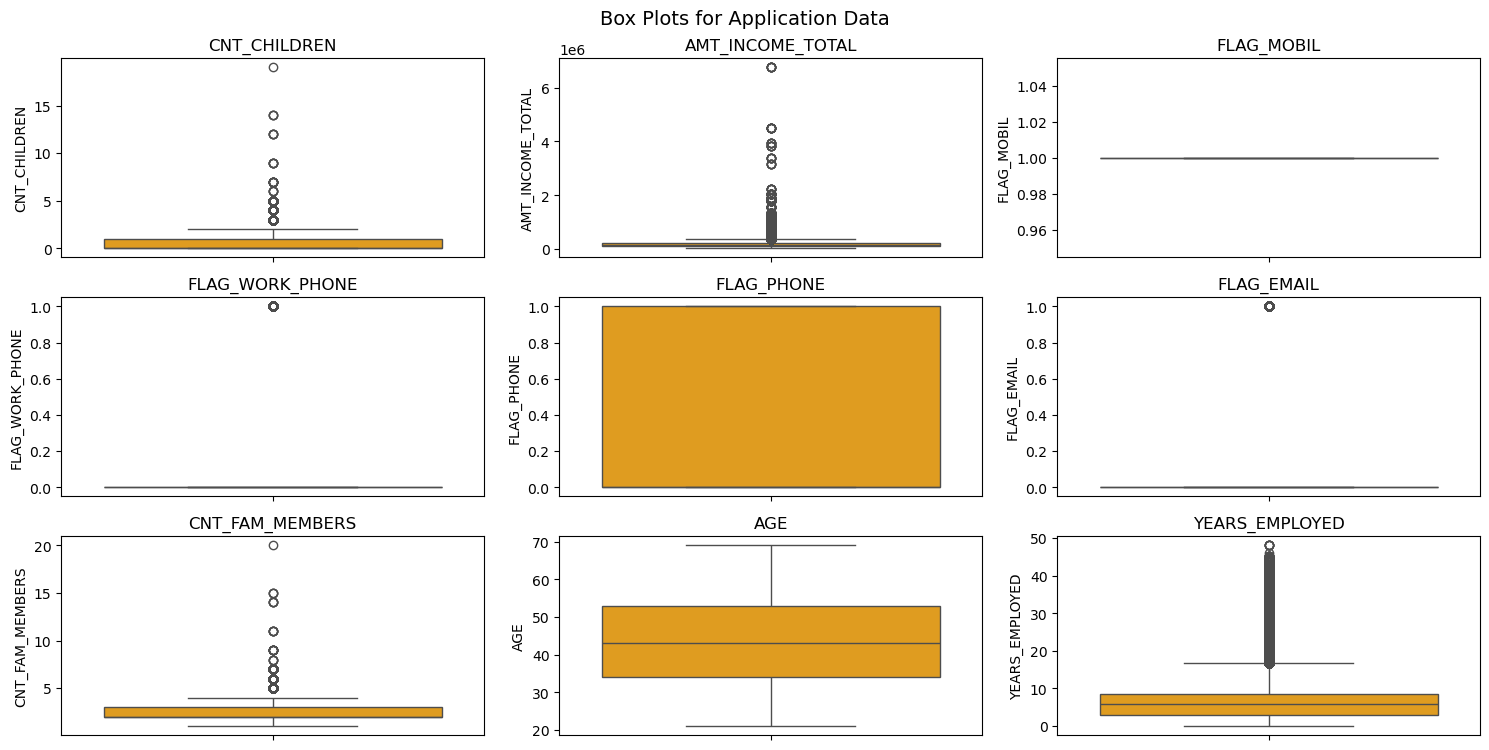

In [13]:
# Drop ID column to remove noise also remove the DAYS_BIRTH and DAYS_EMPLOYED column as values are negative
application_df_ID = application_df.drop(columns=['ID','DAYS_BIRTH','DAYS_EMPLOYED'])
credit_df_ID = credit_df.drop(columns=['ID'])

# Check for missing values in application dataset
print("Missing values in application data:")
print(application_df_ID.isnull().sum())

# Check for missing values in credit dataset
print("\nMissing values in credit data:")
print(credit_df_ID.isnull().sum())

# Check missing values in OCCUPATION_TYPE
print("\nMissing values in OCCUPATION_TYPE:", application_df_ID["OCCUPATION_TYPE"].isnull().sum())

# Histogram for numeric variables in application data (without ID)
application_df_ID.hist(figsize=(12, 8), bins=30, color="green")
plt.suptitle("Histograms for Application Data (Cleaned)", fontsize=14)
plt.tight_layout()
plt.show()

# Histogram for numeric variables in credit data 
plt.figure(figsize=(10, 5))
credit_df_ID["MONTHS_BALANCE"].abs().hist(bins=30, color="purple", edgecolor="black")
plt.suptitle("Histogram for Credit Data", fontsize=14)
plt.title("Distribution of Months Balance")
plt.xlabel("Months Balance")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Scatter plot of income vs. age
plt.figure(figsize=(10, 6))
sns.scatterplot(x=application_df_ID["AGE"], y=abs(application_df_ID["AMT_INCOME_TOTAL"])//365, alpha=0.5, color="blue")
plt.xlabel("Age")
plt.ylabel("Income")
plt.title("Income vs. Age")
plt.show()

# Scatter plot of income vs. employment length
plt.figure(figsize=(10, 6))
sns.scatterplot(x=application_df_ID["YEARS_EMPLOYED"], y=abs(application_df_ID["AMT_INCOME_TOTAL"])//365, alpha=0.5, color="red")
plt.xlabel("Years Employed")
plt.ylabel("Income")
plt.title("Income vs. Years Employed")
plt.show()

# Box plots for all numeric variables
numeric_columns = application_df_ID.select_dtypes(include=[np.number]).columns

plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_columns):
    plt.subplot(len(numeric_columns) // 3 + 1, 3, i + 1)
    sns.boxplot(y=application_df_ID[col], color="orange")
    plt.title(col)

plt.suptitle("Box Plots for Application Data", fontsize=14)
plt.tight_layout()
plt.show()

## THe above table gives a summary. It shows columns are zeros.....

## DATA PREPARATION (CREDIT DATASET)

In [4]:
# Convert MONTHS_BALANCE to absolute values
credit_df["MONTHS_BALANCE"] = credit_df["MONTHS_BALANCE"].abs()

# Group by ID and take the max absolute value of MONTHS_BALANCE
credit_df_grouped = credit_df.groupby("ID", as_index=False)["MONTHS_BALANCE"].max()

# Define a function to assign approval status
def assign_approval(status):
    if str(status).isdigit() and int(status) > 0:
        return 0  # Assign 0 if STATUS is greater than 0
    return 1  # Assign 1 for STATUS values 0, 1, 2, X, C

# Get the max STATUS per ID
status_max = credit_df.groupby("ID")["STATUS"].max().reset_index()

# Merge STATUS with grouped data
credit_df_grouped = credit_df_grouped.merge(status_max, on="ID", how="left")

# Apply the function to create the Approved column in the grouped dataset
credit_df_grouped["Approved"] = credit_df_grouped["STATUS"].apply(assign_approval)

# Remove duplicate IDs if any
credit_df_grouped = credit_df_grouped.drop_duplicates(subset="ID")

# Display duplicates (if any exist, this will print them)
duplicates = credit_df_grouped[credit_df_grouped.duplicated(subset="ID", keep=False)]
print("Duplicate IDs (if any):\n", duplicates)

# Display the processed dataset
print(credit_df_grouped.head())

# Save the processed dataset if needed
credit_df_grouped.to_csv("processed_credit_record.csv", index=False)

Duplicate IDs (if any):
 Empty DataFrame
Columns: [ID, MONTHS_BALANCE, STATUS, Approved]
Index: []
        ID  MONTHS_BALANCE STATUS  Approved
0  5001711               3      X         1
1  5001712              18      C         1
2  5001713              21      X         1
3  5001714              14      X         1
4  5001715              59      X         1


## JOINING BOTH DATASETS


In [17]:
# Load the processed credit dataset (assumed to be saved as "processed_credit_record.csv")
credit_df_grouped = pd.read_csv("processed_credit_record.csv")

# Drop DAYS_BIRTH and DAYS_EMPLOYED from the application data
application_df_cleaned = application_df.drop(columns=["DAYS_BIRTH", "DAYS_EMPLOYED"])

# Save the cleaned application dataset as a CSV file (optional)
application_df_cleaned.to_csv("cleaned_application_data.csv", index=False)

# Load the processed credit dataset (assumed to be saved as "processed_credit_record.csv")
credit_df_grouped = pd.read_csv("processed_credit_record.csv")

# Perform a left join on ID using the cleaned application data
merged_df = application_df_cleaned.merge(credit_df_grouped, on="ID", how="left")

# Save the final merged dataset as a CSV file
merged_df.to_csv("merged_credit_application_data.csv", index=False)

# Remove all rows with any NaN values
final_df = merged_df.dropna()

# Save the final merged dataset (with no NaN values) as a CSV file
final_df.to_csv("Application and Credit dataset.csv", index=False)

print(final_df.head())

        ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
2  5008806           M            Y               Y             0   
3  5008808           F            N               Y             0   
4  5008809           F            N               Y             0   
5  5008810           F            N               Y             0   
6  5008811           F            N               Y             0   

   AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
2          112500.0               Working  Secondary / secondary special   
3          270000.0  Commercial associate  Secondary / secondary special   
4          270000.0  Commercial associate  Secondary / secondary special   
5          270000.0  Commercial associate  Secondary / secondary special   
6          270000.0  Commercial associate  Secondary / secondary special   

     NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  ...  FLAG_WORK_PHONE  FLAG_PHONE  \
2               Married  House / apartment  ... 

## CORRELATIONS & DATA MODELLING

Categorical columns: ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'STATUS']
Numeric columns: ['ID', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'AGE', 'YEARS_EMPLOYED', 'MONTHS_BALANCE', 'Approved']
Data after OneHotEncoding (first 5 rows):
        ID  CNT_CHILDREN  AMT_INCOME_TOTAL  FLAG_MOBIL  FLAG_WORK_PHONE  \
0  5008806             0          112500.0           1                0   
1  5008808             0          270000.0           1                0   
2  5008809             0          270000.0           1                0   
3  5008810             0          270000.0           1                0   
4  5008811             0          270000.0           1                0   

   FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  AGE  YEARS_EMPLOYED  ...  \
0           0           0                2   59      

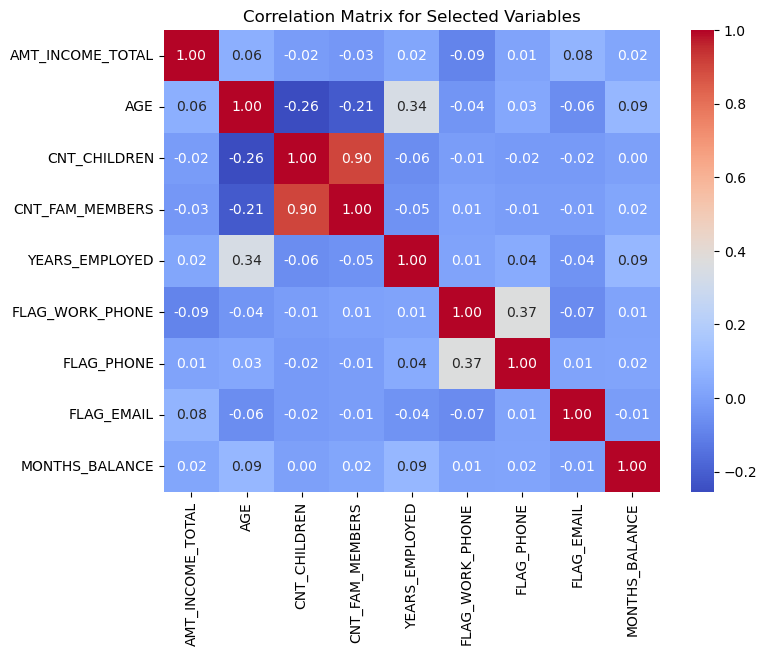

In [16]:
from sklearn.preprocessing import OneHotEncoder

# Load the final merged dataset (without NaN values)
final_df = pd.read_csv("Application and Credit dataset.csv")

# Separate categorical and numeric columns
categorical_cols = final_df.select_dtypes(include=['object']).columns.tolist()
numeric_cols = final_df.select_dtypes(include=[np.number]).columns.tolist()

print("Categorical columns:", categorical_cols)
print("Numeric columns:", numeric_cols)

# Initialize OneHotEncoder with the updated parameter name
encoder = OneHotEncoder(sparse_output=False, drop='first')

# Fit and transform the categorical columns
encoded_array = encoder.fit_transform(final_df[categorical_cols])
encoded_df = pd.DataFrame(encoded_array, 
                          columns=encoder.get_feature_names_out(categorical_cols),
                          index=final_df.index)

# Combine numeric columns with the one-hot encoded categorical columns
final_df_encoded = pd.concat([final_df[numeric_cols], encoded_df], axis=1)

# Display the first 5 rows of the encoded data
print("Data after OneHotEncoding (first 5 rows):")
print(final_df_encoded.head())

# "How do income, occupation, and demographic factors influence an applicant's ability to repay loans?"
relevant_vars = ['AMT_INCOME_TOTAL', 'AGE', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'YEARS_EMPLOYED', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL','MONTHS_BALANCE']

# Check if these columns exist in final_df
print("Available relevant columns:", final_df[relevant_vars].columns.tolist())

# Compute the correlation matrix for the selected variables
corr_matrix = final_df[relevant_vars].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix for Selected Variables")
plt.show()

## Modelling Output and Validation


In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Load the final merged dataset and perform one-hot encoding
final_df = pd.read_csv("Application and Credit dataset.csv")
final_df_encoded = pd.get_dummies(final_df, drop_first=True)

# Define features and target variable as per mentor's suggestion.
# Here, we use key features related to income, mobility, family size, age, employment, and the credit data outcome.
X = final_df_encoded[['AMT_INCOME_TOTAL', 'FLAG_MOBIL',
       'FLAG_WORK_PHONE', 'CNT_FAM_MEMBERS', 'AGE',
       'YEARS_EMPLOYED', 'MONTHS_BALANCE', 'CODE_GENDER_M']]
y = final_df_encoded['Approved']

# Split the dataset into training (70%) and testing (30%) sets (stratify by y to maintain class distribution)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Optionally standardize the features (uncomment if needed)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# Define the models to compare
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier()
}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"Results for {name}:")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    print("Accuracy Score:", accuracy_score(y_test, y_pred))
    print("-" * 50)

Results for Logistic Regression:
Confusion Matrix:
[[   0  170]
 [   0 7371]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       170
         1.0       0.98      1.00      0.99      7371

    accuracy                           0.98      7541
   macro avg       0.49      0.50      0.49      7541
weighted avg       0.96      0.98      0.97      7541

Accuracy Score: 0.9774565707465853
--------------------------------------------------
Results for Decision Tree:
Confusion Matrix:
[[  31  139]
 [ 204 7167]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.13      0.18      0.15       170
         1.0       0.98      0.97      0.98      7371

    accuracy                           0.95      7541
   macro avg       0.56      0.58      0.56      7541
weighted avg       0.96      0.95      0.96      7541

Accuracy Score: 0.9545153162710516
-----------------------------